In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2024-04-12 11:44:26.440844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 11:44:27.679482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/danil/PycharmProjects/image_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = pathlib.Path("/home/danil/Documents/курсовая/image_classification/categories/all_cleaned/")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

19656


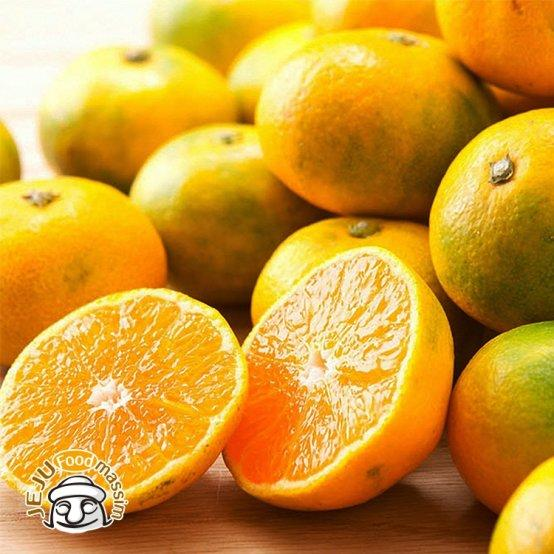

In [4]:
fruits = list(data_dir.glob('fruit/*'))
PIL.Image.open(fruits[0])

In [5]:
batch_size = 32
img_height = 256
img_width = 256

In [41]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="training",
  label_mode='categorical',  
  seed=2,
  image_size=(img_height, img_width),
  pad_to_aspect_ratio=True,  
  batch_size=batch_size)

Found 19656 files belonging to 40 classes.
Using 13760 files for training.


In [43]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="validation",
  label_mode='categorical',   
  seed=2,
  image_size=(img_height, img_width),
  pad_to_aspect_ratio=True,  
  batch_size=batch_size)

Found 19656 files belonging to 40 classes.
Using 5896 files for validation.


In [44]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

In [45]:
class_names = train_ds.class_names

2024-04-12 11:54:50.446082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


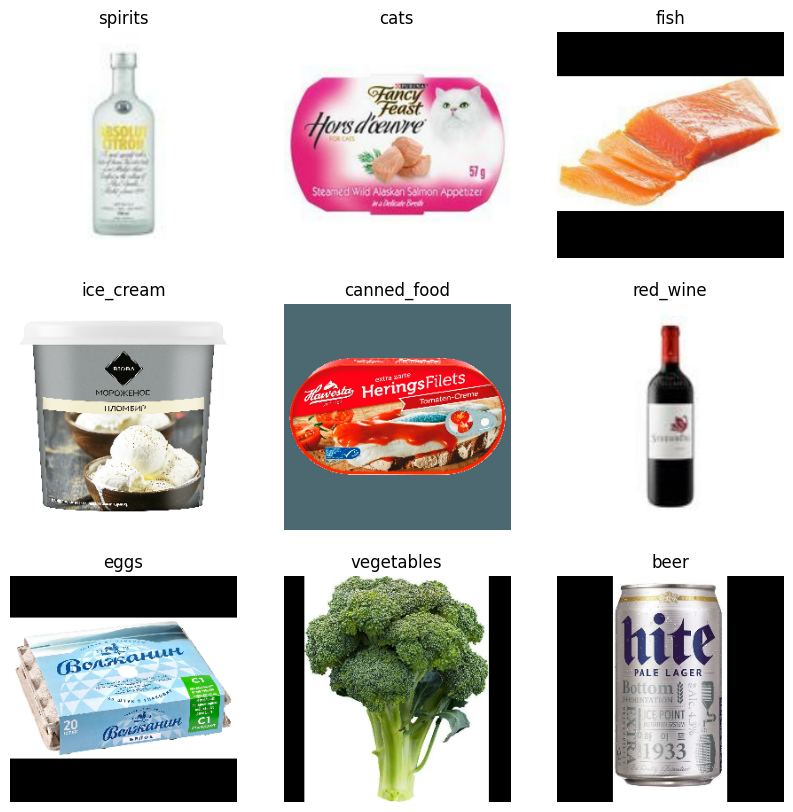

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [47]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.Input(shape=(256, 256, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),  
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),   
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [48]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [49]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,470,056 (28.50 MB)

 Trainable params: 7,470,056 (28.50 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[es]
)

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.0803 - loss: 3.5137 - val_accuracy: 0.2483 - val_loss: 2.7479
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.2390 - loss: 2.7778 - val_accuracy: 0.3479 - val_loss: 2.3938
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.3511 - loss: 2.3361 - val_accuracy: 0.4062 - val_loss: 2.1509
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.4626 - loss: 1.9076 - val_accuracy: 0.4499 - val_loss: 2.0347
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.5730 - loss: 1.4825 - val_accuracy: 0.4824 - val_loss: 2.0034
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.6505 - loss: 1.1633 - val_accuracy: 0.4834 - val_loss: 2.1252
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.7311 - loss: 0.8837 - val_accuracy: 0.4986 - val_loss: 2.0745
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.7741 - loss: 0.7608 - 

In [52]:
results = model.evaluate(test_ds)

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5242 - loss: 2.2140


In [53]:
results

[2.225303888320923, 0.5213994383811951]

In [54]:
predictions = model.predict(test_ds)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


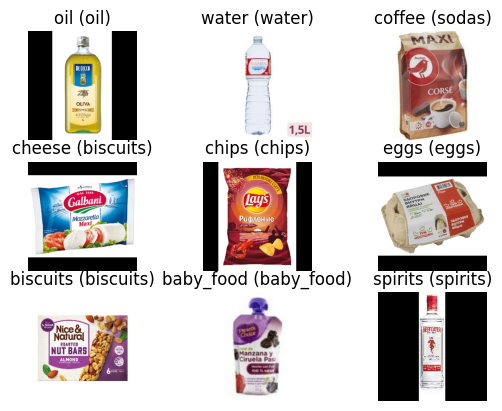

In [66]:
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")

In [56]:
from sklearn.metrics import confusion_matrix

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [58]:
cm = confusion_matrix(labels, predictions)

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [60]:
%%capture
cm = confusion_matrix(labels, predictions, normalize="true")

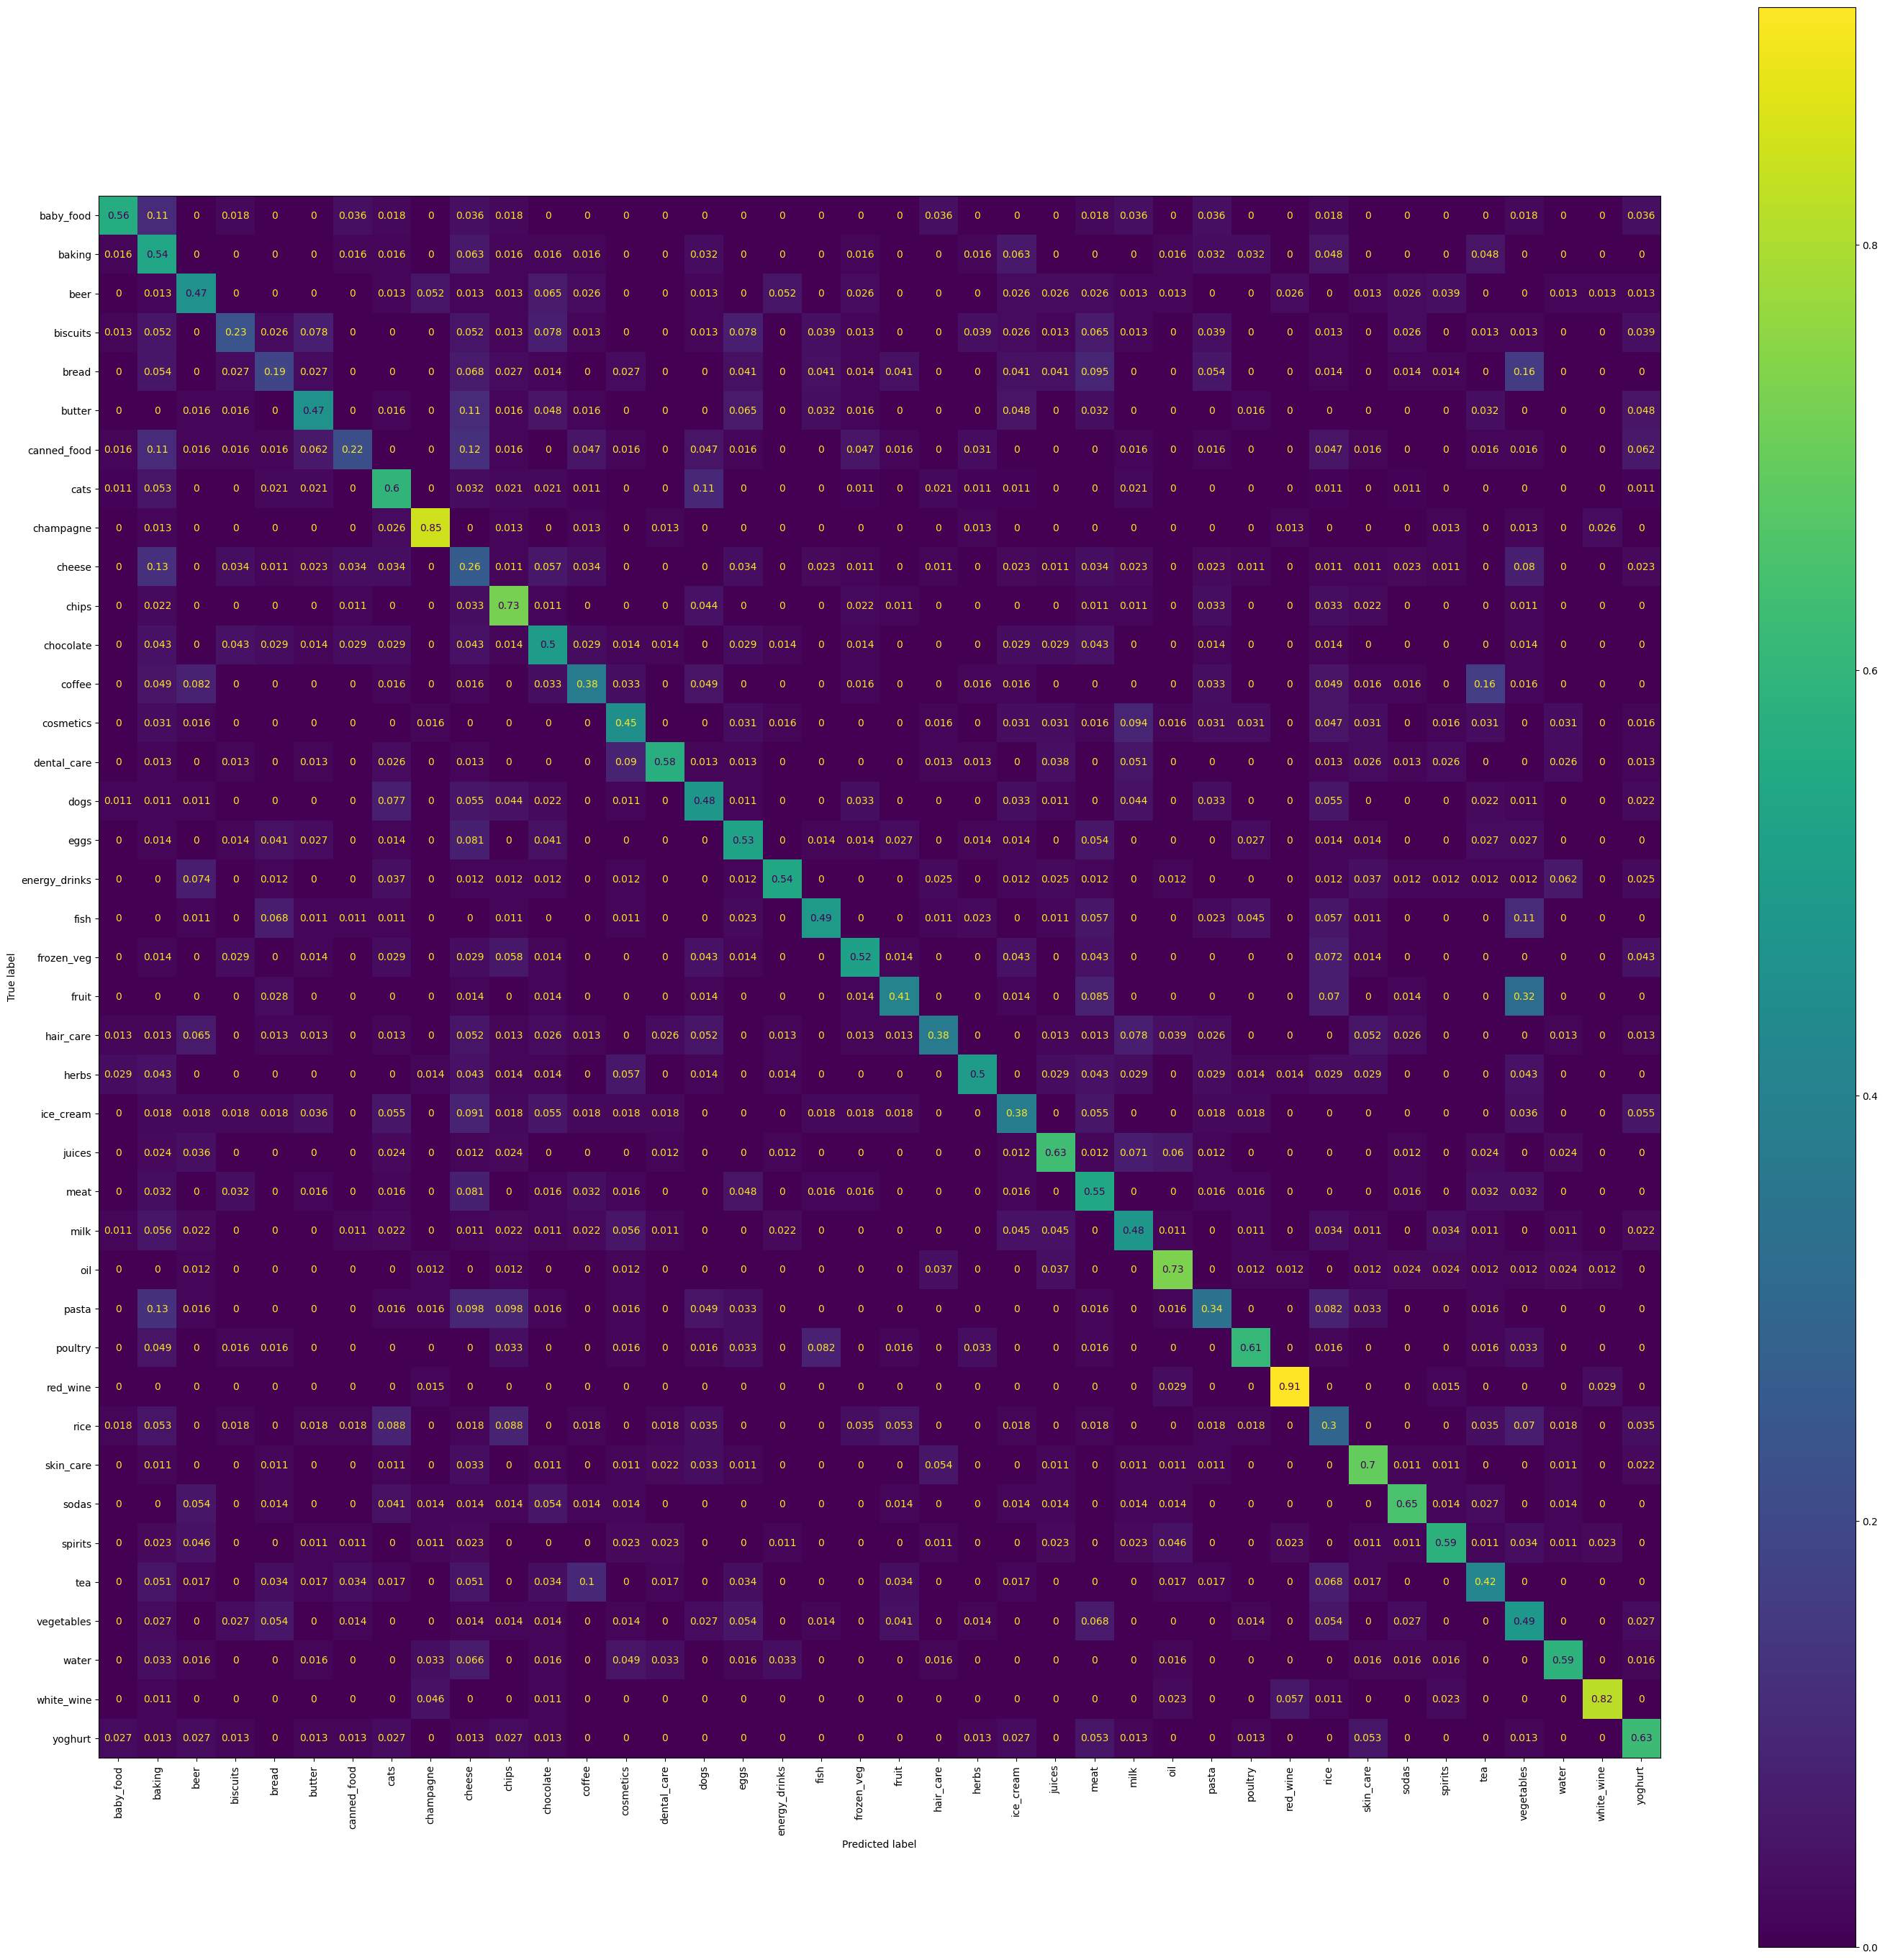

In [61]:
fig, ax = plt.subplots(figsize=(35, 35))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
cmd.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()
# cm.plot(ax=ax)

In [62]:
model.save('ready_models/simple_model.keras')